In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import numpy as np
import random
from tensorflow import keras
from tensorflow.keras import utils as np_utils
#from keras import utils as np_utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout, BatchNormalization, Softmax
from tensorflow.keras import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
import datetime
from time import time
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.layers.pooling import GlobalAveragePooling2D

import sys
sys.path.append("/home/ecbm4040/Final_Project/e4040-2021Fall-Project-SCNN-as6430-as6456-vsk2123/src/")


In [3]:
# CIFAR10 Dataset
from modules.utils import load_data
X_train, y_train = load_data(mode='train')
num_training = 49000
num_validation = 1000

X_val = X_train[-num_validation:, :]
y_val = y_train[-num_validation:]

X_train = X_train[:num_training, :]
y_train = y_train[:num_training]

# Preprocessing: subtract the mean value across every dimension for training data, and reshape it to be RGB size
mean_image = np.mean(X_train, axis=0)
X_train = X_train.astype(np.float32) - mean_image.astype(np.float32)
X_val = X_val.astype(np.float32) - mean_image

X_train = X_train.reshape(-1,3,32,32).transpose(0,2,3,1) / 255
X_val = X_val.reshape(-1,3,32,32).transpose(0,2,3,1) / 255

y_train=np.reshape(y_train, -1)
y_val=np.reshape(y_val, -1)

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)

y_train_dummy = tf.keras.utils.to_categorical(y_train)
y_val_dummy = tf.keras.utils.to_categorical(y_val)
print('Train labels shape (one-hot): ', y_train_dummy.shape)
print('Validation labels shape (one-hot): ', y_val_dummy.shape)

./data/cifar-10-python.tar.gz already exists. Begin extracting...
Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Train labels shape (one-hot):  (49000, 10)
Validation labels shape (one-hot):  (1000, 10)


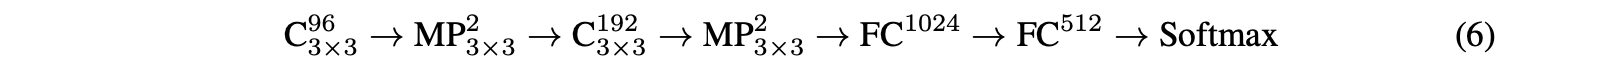

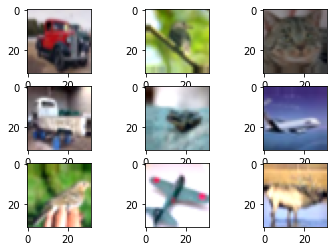

In [9]:
# Data augmentation code

def HSV_perturbations(image):
    """
    Takes an input image and returns it with either the randomly adjusted hue or saturation
    (or may be makes no HSV change at all) with a probability of 1/3
    """
    choice=random.randint(1,3)
    print(choice)
    image = np.array(image)
    if choice ==1:
        return tf.image.random_hue(image, 1/random.randint(1,10))
    elif choice ==2:
        return tf.image.random_saturation(image, 5, 10)
    else:
        return image # so as to avoid not change hue for every image

datagen = ImageDataGenerator(
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.5,1.5]
    )
datagen.fit(X_train)

# Plot sample augmented images
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9):
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].astype(np.uint8))
    plt.show()
    break

In [10]:
from modules.layers import spectralConv2D

def spectralCNN(input_shape):

    model = Sequential()

    model.add(spectralConv2D(96, kernel_size=(3,3),padding="SAME", strides=(1,1), input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))
    model.add(spectralConv2D(192, kernel_size=(3,3),padding="SAME", strides=(1,1)))
    model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))
    model.add(Flatten())
    model.add(Dense(1024,activation="relu"))
    model.add(Dense(512,activation="relu"))
    model.add(Dense(10,activation="softmax"))
    return model
    


In [ ]:
batch_size=128
nb_epochs=50

output_size=10

train_generator = datagen.flow(X_train, y_train, batch_size=batch_size)
valid_generator = datagen.flow(X_val, y_val, batch_size=batch_size)

spectral_cnn_model = spectralCNN(X_train.shape[1:])

spectral_cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history=spectral_cnn_model.fit_generator(train_generator,epochs=nb_epochs,steps_per_epoch=len(X_train)//batch_size, validation_data=valid_generator)


/home/ecbm4040/envTF24/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
382/382 [==============================] - 34s 86ms/step - loss: 8.4571 - accuracy: 0.1782 - val_loss: 1.9152 - val_accuracy: 0.3090
Epoch 2/50
382/382 [==============================] - 32s 84ms/step - loss: 1.9139 - accuracy: 0.2857 - val_loss: 1.9354 - val_accuracy: 0.2670
Epoch 3/50
382/382 [==============================] - 32s 84ms/step - loss: 1.8748 - accuracy: 0.3016 - val_loss: 1.8436 - val_accuracy: 0.3190
Epoch 4/50
382/382 [==============================] - 33s 85ms/step - loss: 1.8334 - accuracy: 0.3134 - val_loss: 1.7928 - val_accuracy: 0.3490
Epoch 5/50
382/382 [==============================] - 32s 85ms/step - loss: 1.7596 - accuracy: 0.3495 - val_loss: 1.5972 - val_accuracy: 0.4290
Epoch 6/50
382/382 [==============================] - 224s 589ms/step - loss: 1.5641 - accuracy: 0.4323 - val_loss: 1.4892 - val_accuracy: 0.4860
Epoch 7/50
382/382 [==============================] - 79s 207ms/step - loss: 1.4152 - accuracy: 0.5006 - val_loss: 1.3289 - val_accura

In [5]:
spectral_cnn_model = spectralCNN(X_train.shape[1:])

spectral_cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


history=spectral_cnn_model.fit(x=X_train, y=y_train,
          batch_size=128,
          epochs=25, 
          validation_data=(X_val, y_val)
              )

Epoch 1/25
383/383 [==============================] - 48s 14ms/step - loss: 1.5964 - accuracy: 0.4111 - val_loss: 1.0333 - val_accuracy: 0.6410
Epoch 2/25
383/383 [==============================] - 5s 13ms/step - loss: 0.9456 - accuracy: 0.6677 - val_loss: 0.8583 - val_accuracy: 0.7060
Epoch 3/25
383/383 [==============================] - 5s 13ms/step - loss: 0.7154 - accuracy: 0.7503 - val_loss: 0.7700 - val_accuracy: 0.7460
Epoch 4/25
383/383 [==============================] - 5s 13ms/step - loss: 0.5541 - accuracy: 0.8075 - val_loss: 0.7476 - val_accuracy: 0.7680
Epoch 5/25
383/383 [==============================] - 5s 13ms/step - loss: 0.4234 - accuracy: 0.8527 - val_loss: 0.6644 - val_accuracy: 0.7820
Epoch 6/25
383/383 [==============================] - 5s 13ms/step - loss: 0.2987 - accuracy: 0.8974 - val_loss: 0.7299 - val_accuracy: 0.7750
Epoch 7/25
383/383 [==============================] - 5s 13ms/step - loss: 0.1917 - accuracy: 0.9360 - val_loss: 0.8107 - val_accuracy: 0.784

In [ ]:
import pickle
with open('history3x3-Generic-SpectralCNN', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
        
spectral_cnn_model.save("3x3-Generic-SpectralCNN.h5")

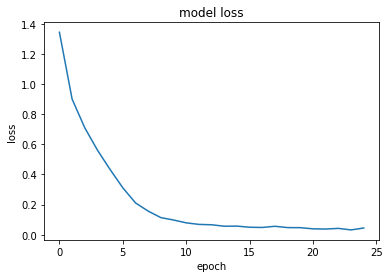

In [7]:
import matplotlib.pyplot as plt 
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()